In [1]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
class User:
    def __init__(self, user_id,importance_features, not_sincerity=False):
        self.user_id = user_id
        self.importance_features = importance_features
        self.survey = pd.DataFrame(columns=['no','temp','hum', 'lux', 'score'])
        self.not_sincerity = not_sincerity
        
    def save_survey(self, no,temp, hum, lux ,score):
        self.survey = self.survey.append({
            "no": no,
            "temp": temp,
            "hum": hum,
            "lux": lux,
            "score": score
        }, ignore_index=True)
    
    def score(self, temp, hum, lux):
        _score = np.array([0,0,0])
        
        if len(self.importance_features) == 0:
            if self.not_sincerity:
                for idx in range(0, len(_score)):
                    _score[idx] = 20
            else:
                one_line = ran.randrange(0, 2)
                if one_line == 0:
                    s = ran.randrange(5, 21, 5)
                    for idx in range(0, len(_score)):
                        _score[idx] = s
                else:
                    for idx in range(0, len(_score)):
                        _score[idx] = ran.randrange(5, 21)
        else:
            if 'temp' in self.importance_features:
                if (temp >= 18) & (temp <= 20):
                    _score[0] = 20
                else:
                    err = 0
                    if temp <= 18:
                        err = 18 - temp
                    else:
                        err = temp - 20
                    _score[0] = 20 - round(err / 2)
            else:
                _score[0] = ran.randrange(17, 21)
                    

            if 'hum' in self.importance_features:
                if (hum >= 40) & (hum <= 60):
                    _score[1] = 20
                else:
                    err = 0
                    if hum <= 40:
                        err = 40 - hum
                    else:
                        err = hum - 60
                    _score[1] = 20 - round(err / 5)
            else:
                _score[1] = ran.randrange(17, 21)


            if 'lux' in self.importance_features:
                if (lux >= 700) & (lux <= 1500):
                    _score[2] = 20
                else:
                    err = 0
                    if temp < 700:
                        err = 700 - lux
                    else:
                        err = lux - 1500
                    _score[2] = 20 - round(err / 100)
            else:
                _score[2] = ran.randrange(17, 21)

        return _score.sum()
    
def generate_features():
    features = ['temp', 'hum', 'lux']
    imp_features = list()
    for f in features:
        is_in = ran.randrange(0,2)
        if is_in == 0:
            imp_features.append(f)
    
    if len(imp_features) == 0:
        is_in = ran.randrange(0, 3)
        imp_features.append(features[is_in])
        
    return imp_features            

In [3]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)
    
now = dt.datetime.now()

for days in range(0, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [6]:
# 정규화
norm_no = users[0].survey['no'] / users[0].survey['no'].max()
norm_temp = users[0].survey['temp'] / users[0].survey['temp'].max()
norm_hum = users[0].survey['hum'] / users[0].survey['hum'].max()
norm_lux = users[0].survey['lux'] / users[0].survey['lux'].max()

for idx in range(0, 100):
        users[idx].survey['no'] = norm_no
        users[idx].survey['temp'] = norm_temp
        users[idx].survey['hum'] = norm_hum
        users[idx].survey['lux'] = norm_lux

In [31]:
features = np.array(['no', 'temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])
models = np.array([])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    RF_imp_features = None
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=100,
                                    max_features=3,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    models = np.append(models, RFModel)
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    if len(set(feature_importance)) == 1:
        RF_imp_features = []
    else:
        feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx[::-1]]
    user_id = user.user_id
    user_imp_features = user.importance_features
    
    imp_length = len(user_imp_features)
    
    if RF_imp_features == None:
        if imp_length == 0:
            RF_imp_features = [_features[0]]
        else:
            RF_imp_features = _features[:imp_length]
        
    _imp_features = RF_imp_features
    imp_features = list()
    
    for _ in ['no', 'temp', 'hum', 'lux']:
        if _ in _imp_features:
            imp_features.append(_)

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(user_imp_features),
        "RF imp features": ",".join(imp_features)
    }, ignore_index=True)

In [32]:
part_user = _record[:50].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,1.945245


In [33]:
unpart_user = _record[50:].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(unpart_user)
compare_cnt = unpart_user[(unpart_user['imp features'] != "") & \
   (unpart_user['imp features'] == unpart_user['RF imp features'])].count()['imp features']
mean_mse = unpart_user[unpart_user['imp features'] == unpart_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,0,0.0


In [34]:
anal_user = part_user.copy()

anal_user['temp'] = part_user['imp features'].map(lambda x: "temp" in x)
anal_user['hum'] = part_user['imp features'].map(lambda x: "hum" in x)
anal_user['lux'] = part_user['imp features'].map(lambda x: "lux" in x)

apt_anal = pd.DataFrame()
apt_anal['온도'] = [anal_user[anal_user['temp'] == True].count().values[0]]
apt_anal['습도'] = [anal_user[anal_user['hum'] == True].count().values[0]]
apt_anal['조도'] = [anal_user[anal_user['lux'] == True].count().values[0]]

apt_anal

,온도,습도,조도
0,32,29,27


In [44]:
features = np.array(['temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])
models = np.array([])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    RF_imp_features = None
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=100,
                                    max_features=3,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    models = np.append(models, RFModel)
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    if len(set(feature_importance)) == 1:
        RF_imp_features = []
    else:
        feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx[::-1]]
    user_id = user.user_id
    user_imp_features = user.importance_features
    
    imp_length = len(user_imp_features)
    
    if RF_imp_features == None:
        if imp_length == 0:
            RF_imp_features = [_features[0]]
        else:
            RF_imp_features = _features[:imp_length]
        
    _imp_features = RF_imp_features
    imp_features = list()
    
    for _ in ['no', 'temp', 'hum', 'lux']:
        if _ in _imp_features:
            imp_features.append(_)

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(user_imp_features),
        "RF imp features": ",".join(imp_features)
    }, ignore_index=True)

In [45]:
part_user = _record[:50].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,2.101745


In [46]:
survey_mean = np.array([])
feature_tmp = np.array([])

for _ in users[0].survey.values:
    feature_tmp = np.append(feature_tmp,_[1:4])
feature_tmp = feature_tmp.reshape(-1, 3)

for survey_no in range(0,540):
    _tmp = np.array([])
    for user_no in range(0, 100):
        _tmp = np.append(_tmp, users[user_no].survey.loc[survey_no]['score'])
    survey_mean = np.append(survey_mean,_tmp.mean())

In [47]:
feature_tmp

array([[0.65625, 0.4875, 0.5789473684210527],
       [0.8125, 0.8125, 0.3157894736842105],
       [0.84375, 0.425, 0.631578947368421],
       ...,
       [0.875, 0.45, 0.8947368421052632],
       [0.46875, 0.9125, 0.5789473684210527],
       [0.5, 0.7375, 0.3157894736842105]], dtype=object)

In [48]:
survey_mean

array([51.11, 50.63, 51.1 , 55.26, 54.08, 49.77, 54.09, 53.29, 48.7 ,
       53.9 , 52.16, 52.41, 50.52, 51.06, 54.95, 55.13, 49.07, 47.96,
       50.78, 51.35, 49.35, 49.31, 52.9 , 51.15, 51.05, 53.26, 55.46,
       52.  , 52.64, 48.9 , 54.81, 50.9 , 52.07, 52.51, 53.16, 50.76,
       51.23, 50.75, 50.68, 55.59, 54.63, 51.85, 50.45, 51.92, 54.21,
       51.84, 51.33, 55.53, 53.81, 54.97, 51.23, 48.89, 51.27, 51.2 ,
       50.77, 50.45, 50.96, 50.94, 50.57, 50.62, 50.11, 53.43, 49.49,
       52.64, 52.39, 52.74, 49.83, 53.67, 50.45, 52.12, 51.41, 50.83,
       49.34, 50.36, 52.71, 50.15, 52.98, 52.71, 49.92, 51.09, 51.12,
       49.79, 52.18, 53.03, 51.1 , 55.1 , 50.63, 57.03, 55.05, 49.95,
       48.94, 49.77, 52.33, 49.9 , 49.65, 51.56, 50.95, 53.47, 50.85,
       48.24, 52.69, 54.01, 50.03, 50.35, 48.98, 52.37, 53.7 , 50.74,
       56.73, 52.33, 55.57, 50.95, 52.23, 55.14, 53.65, 53.92, 50.83,
       53.47, 51.65, 52.15, 51.46, 52.28, 50.79, 51.28, 53.19, 53.03,
       50.6 , 52.04,

In [58]:
anal_mean = pd.DataFrame(columns=["실제 설문점수", "예측 설문점수"])
anal_np = np.array([])

test.reshape(-1, 540).mean(axis=0)

for user_idx in range(0,50):
    anal_np = np.append(anal_np,
        models[user_idx].predict(feature_tmp))

In [62]:
for idx,pre in enumerate(anal_np.reshape(-1, 540).mean(axis=0)):
    anal_mean.loc[idx] = [
        survey_mean[idx],
        pre
    ]

In [65]:
(anal_mean['실제 설문점수'] - anal_mean['예측 설문점수']).abs().mean()

6.410314814814812

[0.15598349 0.11469971 0.72931679]
[0.21387619 0.15727008 1.        ]
0.7015884347479412


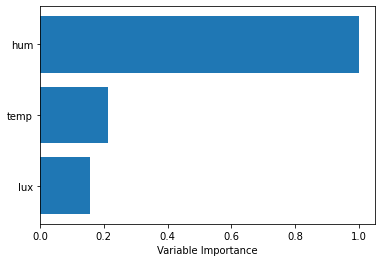

In [23]:
features = np.array(['temp', 'hum', 'lux'])

RFModel = RandomForestRegressor(n_estimators=20,
                                max_features=3,
                            oob_score=False,random_state=531)
RFModel.fit(X_train, y_train.ravel())
prediction = RFModel.predict(X_test)

mse = mean_squared_error(y_test,prediction)

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

print(RFModel.feature_importances_)
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx[::-1]]

print(mse)
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()